## Part1:Build a Neural Network with one hidden layer to be trained and tested on Fashion-MNIST dataset. Code from scratch in Python

In [173]:
# Read Fashion MNIST dataset
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams #An instance of RcParams for
#handling default matplotlib values
import string
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import struct
from scipy.special import expit
# The expit function, also known as the logistic function, is defined as
#expit(x)=1/(1+exp(-x)). It is the inverse of the logit
#function
from sklearn.manifold import TSNE
# transform the data into 2-dimensional
from ast import literal_eval
import util_mnist_reader
X_train, y_train = util_mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = util_mnist_reader.load_mnist('data/fashion', kind='t10k')

X_test_for_cnn1 = X_test
# Your code goes here . . .
X_train_cnn1 = X_train
y_train_cnn1 = y_train

X_test_cnn1 = X_test
y_test_cnn1 = y_test

RANDOM_SEED =42
np.random.seed(RANDOM_SEED)

In [200]:
y_train.shape

(60000,)

In [60]:
X_train.shape

(60000, 784)

In [80]:
y_train.shape

(48000,)

In [2]:
X_test.shape

(10000, 784)

In [3]:
y_test.shape

(10000,)

Maximum likelihood estimation is a method that determines values for the parameters of a model. The parameter values are found such that they maximise the likelihood that the process described by the model produced the data that were actually observed

In [4]:
# MLE works by picking the highest value and return it as a predicted class 
# for the input
def mle(y, axis=1):
    return np.argmax(y, axis)



def one_hot(y, n_labels):
    mat = np.zeros((len(y), n_labels))
    for i, val in enumerate(y):
        mat[i, val] = 1
    return mat

#Regularization
def L2_reg(lambda_, w1, w2):
    return (lambda_ / 2.0) * (np.sum(w1 ** 2) + np.sum(w2 ** 2))


def L1_reg(lambda_, w1, w2):
    return (lambda_ / 2.0) * (np.abs(w1).sum() + np.abs(w2).sum())


def cross_entropy(outputs, y_target):
    return -np.sum(np.log(outputs) * y_target, axis=1)

In [5]:
class NeuralNetwork:
    
    #2-layer Neural Network
    #1.Input Layer
    #2.Weights1
    #3.Hidden Layer
    #4.Weights2
    #5.Output Layer
    def __init__(self, x, y):
        self.input = x
        self.weights1 = np.random.rand(self.input.shape[1],4)
        self.weights2 = np.random.rand(4,1)
        self.y          = y
        self.output     = np.zeros(self.y.shape)
        
    #Feedforward
    #y = sigmoid(W2 sigmoid(W1x + b1) +b2)
    
    def feedforward(self):
        self.layer1 = sigmoid(np.dot(self.input, self.weights1))
        self.output = sigmoid(np.dot(self.layer1, self.weights2))
            
    #update our weights and biases
    #get the appropriate amount to adjust the weights
    #and biases need to know the derivative of the loss 
    #function with respect to the weights and biases
    def backprop(self):
        #application of the chain rule to find derivative
        #of the loss function with respect to weights2 and weights1
        d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output) * sigmoid_derivative(self.output)))
        d_weights1 = np.dot(self.input.T,  (np.dot(2*(self.y - self.output) * sigmoid_derivative(self.output), self.weights2.T) * sigmoid_derivative(self.layer1)))
    # update the weights with the derivative (slope) of the loss function
        self.weights1 += d_weights1
        self.weights2 += d_weights2

In [6]:
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

10 classes of possible fasion products

In [7]:
def plot_product(X, y, idx):
    img = X[idx].reshape(28,28)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title('true label: %s' % CLASS_NAMES[y[idx]])
    plt.colorbar()
    plt.grid(False)
    plt.show()
    
def plot_error(model):
    plt.plot(range(len(model.error_)), model.error_)
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.show()

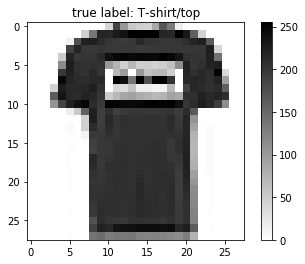

In [8]:
# Exploration
plot_product(X_train,y_train,idx=1)

In [9]:
X_train[1].reshape(28,28)

array([[  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 188, 103,
         54,  48,  43,  87, 168, 133,  16,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0,   0,  49, 136, 219, 216, 228, 236,
        255, 255, 255, 255, 217, 215, 254, 231, 160,  45,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  14, 176, 222, 224, 212, 203, 198, 196,
        200, 215, 204, 202, 201, 201, 201, 209, 218, 224, 164,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 188, 219, 200, 198, 202, 198, 199, 199,
        201, 196, 198, 198, 200, 200, 200, 200, 201, 200, 225,  41,   0,
          0,   0],
       [  0,   0,   0,   0,  51, 219, 199, 203, 203, 212, 238, 248, 250,
        245, 249, 246, 247, 252, 248, 235, 207, 203, 203, 222, 140,   0,
          0,   0],
       [  0,   0,   0,   0, 116, 226, 206, 204, 207, 204, 101,  75,  47,
         73,  48,  50,  45,  51,  63, 113, 222, 202, 206, 220, 224,   0,
          0,   0],
       [  

Lower dimensional representation of some of the products using t_SNE
We will transform the data into 2-dimensional using the implementation from scikit-learn

In [10]:
X_test_tsne = TSNE(n_components=2, random_state=RANDOM_SEED).fit_transform(X_test)

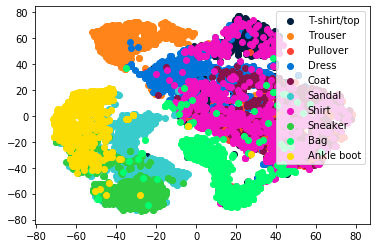

In [11]:



# Different Colors represent each class

colors = ['rgb(0,31,63)', 'rgb(255,133,27)', 'rgb(255,65,54)', 'rgb(0,116,217)', 'rgb(133,20,75)', 'rgb(57,204,204)',
'rgb(240,18,190)', 'rgb(46,204,64)', 'rgb(1,255,112)', 'rgb(255,220,0)',
'rgb(76,114,176)', 'rgb(85,168,104)', 'rgb(129,114,178)', 'rgb(100,181,205)']


def plot_embedding_v1(X_embeded, y):
    for k, i in enumerate(np.unique(y.astype(np.int))):
        plt.scatter(X_embeded[y == i, 0],
                   X_embeded[y == i, 1],
                   color = '#%02x%02x%02x' % literal_eval(colors[k][3:]), 
                    label = CLASS_NAMES[k])
    plt.legend()
    plt.show()
    
plot_embedding_v1(X_test_tsne,y_test)



# plot the images of items in the dataset
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAMES[predicted_label],
                                100*np.max(predictions_array),
                                CLASS_NAMES[true_label]),
                                color=color)
    
#Plot the distribution bar for the 10 classes
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# plot out more than one of the items and it's distribution bar for 10 classes
def plot_image_grid(X_test, y_test, y_hat, num_rows=5, num_cols=3):
  num_images = num_rows*num_cols
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, y_hat, y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_hat,  y_test)

State-of-the-art results(SOTA) on various Machine Learning problems are obtained via Neural Nets

Background
Sigmoid (and it's derivative)
𝜎(𝑥)=1/1+𝑒−𝑥

In [12]:
#Activation function
def sigmoid(z):
    return 1.0/ (1.0 + np.exp(-z))

First derivative of Sigmoid
𝑑𝜎(𝑥)/𝑑(𝑥)=𝜎(𝑥)⋅(1−𝜎(𝑥))

In [13]:
# For Backpropagation
# to know the appropriate amount to adjust the weights and
#biases need to know the derivative of the loss function
#with respect to the weights and biases

# Derivative of a function is simply the slope of the function

def sigmoid_prime(z):
    sg = sigmoid(z)
    return sg * (1 - sg)

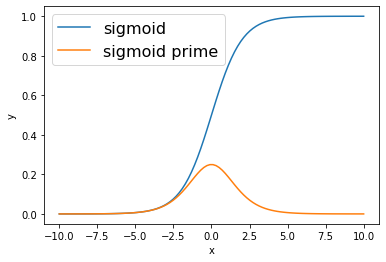

In [14]:
# graph of sigmoid and sigmoid prime
x = np.linspace(-10., 10., num=100)
sig = sigmoid(x)
sig_prime = sigmoid_prime(x)

plt.plot(x, sig, label="sigmoid")
plt.plot(x, sig_prime, label="sigmoid prime")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(prop={'size' : 16})
plt.show()

# Softmax: output depends only on input
and the elements of the resulting vector sum to 1

Softmax function, an activation function that turns numbers aka logits into probabilities that sum to one. 
Outputs a vector that represents the probability distributions of a list of potential outcomes.




## Softmax


$$\sigma(z)_j = \frac{e^{z_j}}{\sum_{K}^{k=1}e^{z_k}} \text{for}\,j = 1,...,k$$



In [15]:
def softmax(z):
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

In probability theory, the output of the softmax function is sometimes used as a representation of a categorical distribution.

## Backpropagation

1.Make a forward pass(uses the data and the weights of the
network to compute a prediction)
2. Calculate the error(based on the prediction and the
provided labels)
3. Make backward pass(backpropagation)(propagates the error through the network,starting from the final layer. Thus, the weights get updated based on the error, little by little)


example for XOR

### XOR

| Input 1 	| Input 2 	| Output 	|
|---------	|---------	|--------	|
| 0       	| 0       	| 0      	|
| 0       	| 1       	| 1      	|
| 1       	| 0       	| 1      	|
| 1       	| 1       	| 0      	|


<img src="https://wantee.github.io/assets/images/posts/xor.png" width="60%">

In [16]:
epochs = 50000
# epochs parameter controls how many times our algorithm will "see"
# the data during training
input_size, hidden_size, output_size = 2, 3, 1
LR = .1 # learning rate

#learning rate parameter controls how quickly our Neural Network will learn from new data and 
#forget what already knows

In [17]:

#Training Data
X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([ [0],   [1],   [1],   [0]])

In [18]:
w_hidden = np.random.uniform(size=(input_size, hidden_size))
w_output = np.random.uniform(size=(hidden_size, output_size))
print (w_hidden)

[[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]]


## Implementation of the Backprop algorithm:

In [19]:
for epoch in range(epochs):
    
    #Forward
    # we take the dot product of the data X and W_hidden
    #and apply our activation function to obtain the output
    #of our hidden layer. We obtain the predictions by taking the
    #dot product of the hidden layer output and W_output
    
    # Multiply a matrix by another matrix we need to do the "dot product"
    #of rows and columns
    act_hidden = sigmoid(np.dot(X, w_hidden))
    #sigmoid as activation function
    output = np.dot(act_hidden, w_output)
    
    #Calculate error
    error = y - output
    
    # we calculate the difference between the true values and the
    # predicted ones
    
    if epoch % 5000 == 0:
        print(f'error sum {sum(error)}')
        
        
    
    # Backward
    dZ = error * LR
    w_output += act_hidden.T.dot(dZ)
    dH = dZ.dot(w_output.T) * sigmoid_prime(act_hidden)
    w_hidden += X.T.dot(dH)
    
    # we use the calculated error to adjust the weights.
    # we need the results from the forward pass act_hidden
    #to calculate W_output and calculate the first derivative
    # using sigmoid_prime to update W_hidden

error sum [-1.77496016]
error sum [0.00586565]
error sum [0.00525699]
error sum [0.0003625]
error sum [-0.00064657]
error sum [0.00189532]
error sum [3.79101937e-08]
error sum [7.47957252e-13]
error sum [1.48769885e-14]
error sum [1.39888101e-14]


In [20]:
test_data = X[0] #[0,0]
act_hidden = sigmoid(np.dot(test_data, w_hidden))
np.dot(act_hidden, w_output)

array([1.99840144e-14])

## Classifying Images
Neural Network with 1 hidden layer

In [21]:


class NNClassifier:

    def __init__(self, n_classes, n_features, n_hidden_units=30,
                 l1=0.0, l2=0.0, epochs=500, learning_rate=0.01,
                 n_batches=1, random_seed=None):

        if random_seed:
            np.random.seed(random_seed)
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.w1, self.w2 = self._init_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.n_batches = n_batches
        
        
    #Initializing the weights
    #uniform distribution with values between -1 and 1 for our initial weights
    def _init_weights(self):
        w1 = np.random.uniform(-1.0, 1.0,
                               size=(self.n_hidden_units, self.n_features))        
        w2 = np.random.uniform(-1.0, 1.0,
                               size=(self.n_classes, self.n_hidden_units))
        return w1, w2
      
    def _forward(self, X):
        net_input = X.copy()
        net_hidden = self.w1.dot(net_input.T)
        act_hidden = sigmoid(net_hidden)
        net_out = self.w2.dot(act_hidden)
        act_out = sigmoid(net_out)
        return net_input, net_hidden, act_hidden, net_out, act_out
    
    def _backward(self, net_input, net_hidden, act_hidden, act_out, y):
        sigma3 = act_out - y
        sigma2 = self.w2.T.dot(sigma3) * sigmoid_prime(net_hidden)
        grad1 = sigma2.dot(net_input)
        grad2 = sigma3.dot(act_hidden.T)
        return grad1, grad2      
    
    
    # Measuring the error
    # Cross-Entropy loss(log loss) measures the performance of a
    # Classification model whose output is a probability 
    def _error(self, y, output):
        L1_term = L1_reg(self.l1, self.w1, self.w2)
        L2_term = L2_reg(self.l2, self.w1, self.w2)
        # after computing the cross-Entropy loss we add the
        # regularization terms and calculate the mean error
        #
        error = cross_entropy(output, y) + L1_term + L2_term
        return 0.5 * np.mean(error)

    # We do an additional step before returning the gradients
    #----apply L1 and L2 Regularization.
    # Regularization is used to guide our training towards simpler methods by penalizing
    #large values for our parameters W
    
    # In order to create less complex(parsimonious-means that unwilling
    # to spend money or use resources) model when you have a large 
    #number of features in your dataset
    #Some of the Regularization techniques used to address over-fitting
    #and feature selection are:
    #1. L1 Regularization - Lasso Regression
    #2. L2 Regularization - Ridge Regression
    
    #The key difference between these two is the penalty term
    
    #Ridge regression adds "squared magnitude" of coefficient as
    #penalty term to the loss function.
    
    #Lasso Regression(Least Absolute Shrinkage and Selection Operator)
    # adds"absolute value of magnitude" of coefficient as penalty term to the loss function
    
    # Lasso shrinks the less important feature's coefficient to zero thus, removing
    #some feature altogether. Works well for feature selection in case
    #we have a huge number of features
    
    #cross-validation, stepwise regression work well with a small set of features
    # L1 L2 are greate when dealing with a large set of features.
    
    
    
    def _backprop_step(self, X, y):
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(X)
        y = y.T

        grad1, grad2 = self._backward(net_input, net_hidden, act_hidden, act_out, y)

        # regularize
        grad1 += (self.w1 * (self.l1 + self.l2))
        grad2 += (self.w2 * (self.l1 + self.l2))

        error = self._error(y, act_out)
        
        return error, grad1, grad2
    # predictions in NN includes applying a forward step on the
    #data. But the result of it is a vector of values representing 
    # how strong the belif for each class is for the data.
    
    #We'll use Maximum likelihood estimation (MLE) to obtain our final
    #predictions
    def predict(self, X):
        Xt = X.copy()
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(Xt)
        return mle(net_out.T)
    #predict_proba returns a probability distribution over all
    # classes, representing how likely each class is to be
    #correct. (We obtain it by applying the softmax function)
    # to the result of the forward step
    
    
    def predict_proba(self, X):
        Xt = X.copy()
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(Xt)
        return softmax(act_out.T)

    # Training Method
    
    def fit(self, X, y):
        self.error_ = []
        X_data, y_data = X.copy(), y.copy()
        y_data_enc = one_hot(y_data, self.n_classes)
                
        X_mbs = np.array_split(X_data, self.n_batches)
        y_mbs = np.array_split(y_data_enc, self.n_batches)
        
        
        #For each epoch, we apply the backprop algorithm,
        #evalute the error and the gradient with respect to the
        #weights. 
        for i in range(self.epochs):
            
            epoch_errors = []

            for Xi, yi in zip(X_mbs, y_mbs):
                
                # update weights
                error, grad1, grad2 = self._backprop_step(Xi, yi)
                epoch_errors.append(error)
                
                #We then use the learning rate and gradients to
                #update the weights
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            self.error_.append(np.mean(epoch_errors))
        return self
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

## Evalution
Put our NN model to the test

In [22]:
N_FEATURES = 28 * 28 #28 x 28 pixels for the images
N_CLASSES = 10

nn = NNClassifier(
    n_classes=N_CLASSES,
    n_features=N_FEATURES,
    n_hidden_units=50,
    l2=0.5,
    l1=0.0,
    epochs=300,
    learning_rate=0.001,
    n_batches=25,
    random_seed=RANDOM_SEED
).fit(X_train, y_train);

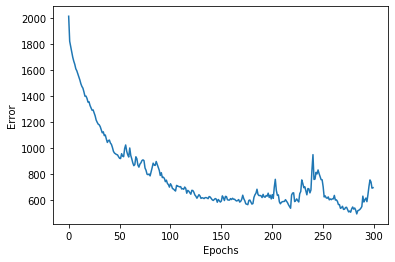

In [23]:
plot_error(nn)

In [24]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))
print('Test Accuracy: %.2f%%' % (nn.score(X_test, y_test) * 100))

Train Accuracy: 42.35%
Test Accuracy: 41.96%


Seems like our model can't continue to reduce the error 150 epochs or so.

## Exploring predictions

Classes
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [25]:
nn.predict_proba(X_test[1:2])

#predict_proba returns a probability distribution over all
# classes, representing how likely each class is to be
#correct. (We obtain it by applying the softmax function)
# to the result of the forward step



array([[0.08102395, 0.09882546, 0.15503516, 0.0808046 , 0.17582111,
        0.08318422, 0.08085383, 0.08078073, 0.08091687, 0.08275408]])

In [26]:
# for all the items in the dataset the probability distribution over all classes
y_hat = nn.predict_proba(X_test)

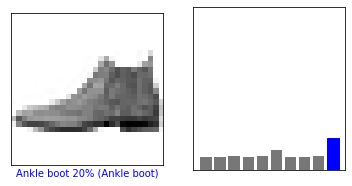

In [27]:
i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, y_hat, y_test, X_test)
plt.subplot(1, 2, 2)
plot_value_array(i, y_hat,  y_test)

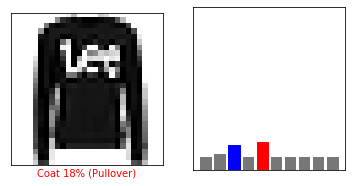

In [28]:
i = 1
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, y_hat, y_test, X_test)
plt.subplot(1, 2, 2)
plot_value_array(i, y_hat,  y_test)

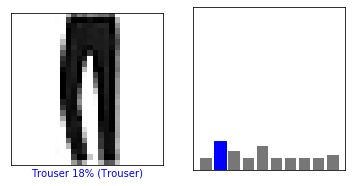

In [29]:
i = 2
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, y_hat, y_test, X_test)
plt.subplot(1, 2, 2)
plot_value_array(i, y_hat,  y_test)

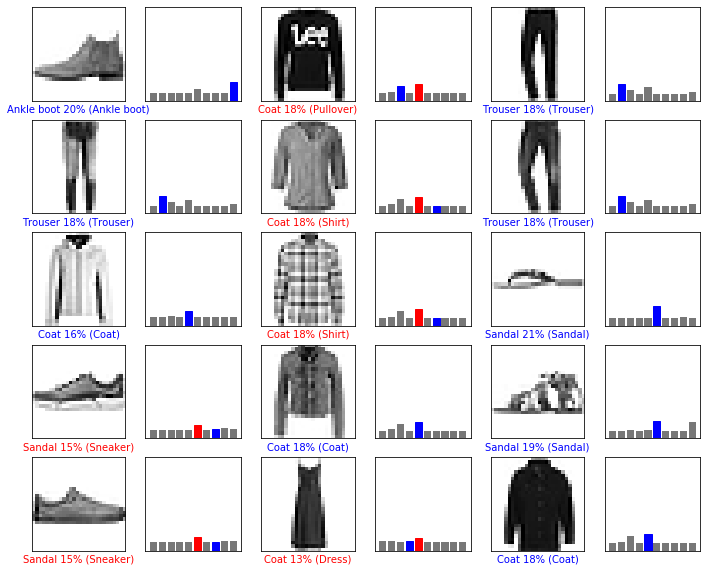

In [30]:
plot_image_grid(X_test, y_test, y_hat)

## Improving the accuracy

Jagged line on the training error chart shows the inability of our model to converge. We use the Backpropagation algorithm to train our model.

Training Neural Nets converge much faster when data is normalized

Use scikit-learn's scale to normalize our data

Center to the mean and component wise scale to unit variance

In [31]:
from sklearn.preprocessing import scale

X_train_scaled = scale(X_train.astype(np.float64))
X_test_scaled = scale(X_test.astype(np.float64))

nn = NNClassifier(
    n_classes=N_CLASSES, 
    n_features=N_FEATURES,
    n_hidden_units=50,
    l2=0.5,
    l1=0.0,
    epochs=300,
    learning_rate=0.001,
    n_batches=25,
    random_seed=RANDOM_SEED
).fit(X_train_scaled, y_train);

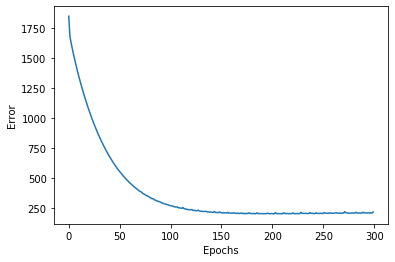

In [32]:
plot_error(nn)

In [33]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train_scaled, y_train) * 100))
print('Test Accuracy: %.2f%%' % (nn.score(X_test_scaled, y_test) * 100))

Train Accuracy: 92.71%
Test Accuracy: 86.75%


In [34]:
y_hat = nn.predict_proba(X_test_scaled)

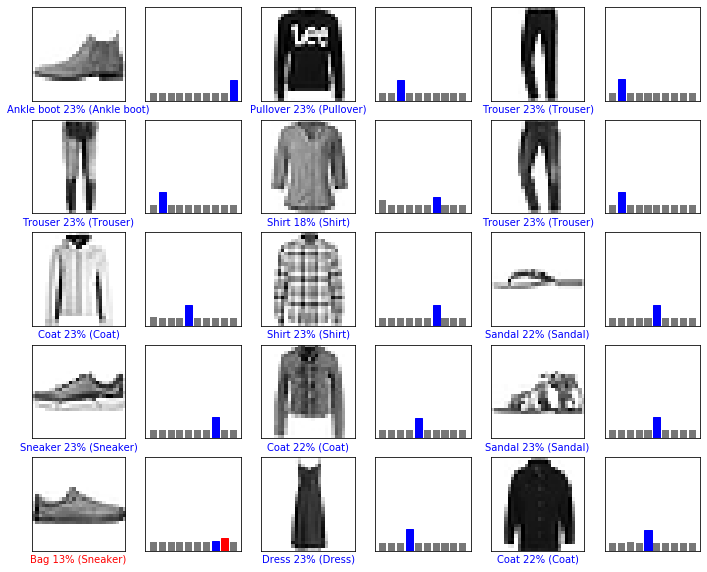

In [35]:
plot_image_grid(X_test, y_test, y_hat)

In [137]:
X_test.shape

(10000, 28, 28, 1)

In [144]:
y_test.shape

(10000,)

Confusion_matrix

In [142]:
matrix = confusion_matrix(y_test, nn.predict(X_test))

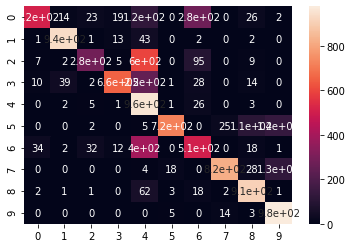

In [143]:
sns.heatmap(matrix,annot=True)

## Part 2:Build multi-layer Neural Network with open-source neural_network library, Keras on Fashion-MNIST dataset

Comparing neural network depth:
3, 6 (NN-3 vs NN-6 )
Improving predictions with epochs (5 vs 50)


In [36]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

print (tf.__version__)


2.1.0-dev20191014


Using TensorFlow backend.


In [37]:
#image: 28x28 arrays, pixel values: 0 to 255
#labels: array of integers: 0 to 9 => class of clothings
#Training set: 60,000 images, testing set: 10,000 images

#class names are not included, need to create them to plot the images
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

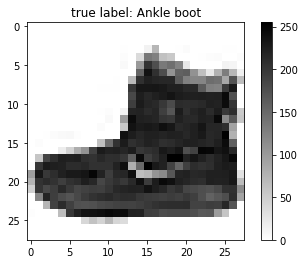

In [38]:
#Visualize the first image from the training dataset
plot_product(X_train,y_train,idx=0)

In [39]:
# normalize the data dimensions so that they are approximately the same scale
#Training Neural Nets converge much faster when data is normalized

#Use scikit-learn's scale to normalize our data

#Center to the mean and component wise scale to unit variance

from sklearn.preprocessing import scale

X_train_scaled = scale(X_train.astype(np.float64))
X_test_scaled = scale(X_test.astype(np.float64))



## Training the first NN model

1. Build the architecture
2. Compile the model
3. Train the model
4. Evaluate the model


1. Build the architecture
Deciding the number of layers and activation functions. We'll start with
a 3-layer NN. In the first layer we 'flatten' the data, so that a(28x28) shape flattens to 784. The second layer is a dense layer with a ReLu activation function and has 128 neurons. The last layer is a dense layer with a softmax activation function that classifies the 10 categories of the data and has 10
neurons

## try to reshape data from 2D to 3D


In [40]:
X_train_3D = X_train.reshape((X_train.shape[0],28, 28))
X_train_3D.shape

(60000, 28, 28)

In [ ]:
X_train.shape

In [93]:
y_train.shape

(48000,)

In [146]:
y_test.shape

(10000,)

In [41]:

X_test_3D = X_test.reshape((X_test.shape[0],28,28))
X_test_3D.shape

(10000, 28, 28)

In [42]:
# Step 1 - Build the architecture
# Model a simple 3-layer neural network
model_3 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_3.summary() 



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## Compile the model
1.Lost function: calculates the difference between the output and the target variable. It measures the
accuracy of the model during training and we want to minimize this function

Cross- entropy is the default loss function to use for a multi-class classification problem and it's sparse because our targets are not one-hot encodings but are integers

2. Optimizer: how the model is updated and is based on the data and the loss function. Adam is an extensioln to the classic stochastic gradient descent
3. Metrics- monitors the training and testing steps. Accuracy is a common metric and it measures the fraction of images that are correctly classified

In [43]:
# Step 2 - Compile the model
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

Epochs =5

In [44]:
#Step 3 - Train the model, by fitting it to the training data
# 5 epochs, and split the training set into 80/20 for validation
model_3.fit(X_train_3D, y_train, epochs=5, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 4s 87us/sample - loss: 4.0753 - accuracy: 0.6832 - val_loss: 0.8110 - val_accuracy: 0.7172
Epoch 2/5
48000/48000 [==============================] - 6s 129us/sample - loss: 0.7267 - accuracy: 0.7457 - val_loss: 0.6783 - val_accuracy: 0.7431
Epoch 3/5
48000/48000 [==============================] - 6s 116us/sample - loss: 0.6238 - accuracy: 0.7779 - val_loss: 0.6746 - val_accuracy: 0.7846
Epoch 4/5
48000/48000 [==============================] - 3s 64us/sample - loss: 0.5665 - accuracy: 0.8031 - val_loss: 0.5289 - val_accuracy: 0.8075
Epoch 5/5
48000/48000 [==============================] - 3s 64us/sample - loss: 0.5288 - accuracy: 0.8123 - val_loss: 0.5208 - val_accuracy: 0.8247


## step 4-Evaluate the model



In [45]:
test_loss, test_acc = model_3.evaluate(X_test_3D, y_test)
print("Model - 3 layers - test loss:", test_loss * 100)
print("Model - 3 layers - test accuracy:", test_acc * 100)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Model - 3 layers - test loss: 56.52276450157166
Model - 3 layers - test accuracy: 81.38999938964844


numpy.argmax(a, axis=None, out=None)
Returns the indices of the maximum values along an axis.

In [157]:
model_3_predict = model_3.predict(X_test_3D)
model_3_predict_cm= [np.argmax(t) for t in model_3_predict]

In [155]:
def one_hot(y, n_labels):
    mat = np.zeros((len(y), n_labels))
    for i, val in enumerate(y):
        mat[i, val] = 1
    return mat

In [156]:
y_test_enc = one_hot(y_test,10)

In [158]:
y_test_cm = [np.argmax(t) for t in y_test_enc]

Confusion Matrix

In [159]:
model_3_cm = confusion_matrix(y_test_cm, model_3_predict_cm)

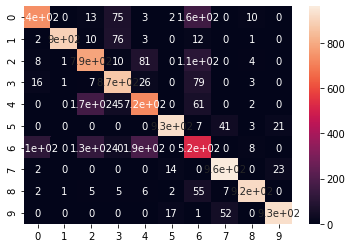

In [160]:
sns.heatmap(model_3_cm,annot=True)

## Deeper layer more accurate?

## NN-6 (6-layer neural network)

In [46]:
# Model a simple 6-layer neural network 
model_6 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
#model_6.summary() 
model_6.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
#Train the NN-6 with 5 epochs 
model_6.fit(X_train_3D, y_train, epochs=5, validation_split=0.2)

#Evaluate the model with test datasets
test_loss, test_acc = model_6.evaluate(X_test_3D,y_test)
print("Model - 6 layers - test loss:", test_loss * 100)
print("Model - 6 layers - test accuracy:", test_acc * 100)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 6s 122us/sample - loss: 1.1387 - accuracy: 0.7560 - val_loss: 0.5645 - val_accuracy: 0.8002
Epoch 2/5
48000/48000 [==============================] - 6s 135us/sample - loss: 0.5003 - accuracy: 0.8245 - val_loss: 0.4538 - val_accuracy: 0.8437
Epoch 3/5
48000/48000 [==============================] - 7s 142us/sample - loss: 0.4566 - accuracy: 0.8362 - val_loss: 0.4618 - val_accuracy: 0.8415
Epoch 4/5
48000/48000 [==============================] - 6s 117us/sample - loss: 0.4242 - accuracy: 0.8467 - val_loss: 0.4406 - val_accuracy: 0.8461
Epoch 5/5
48000/48000 [==============================] - 5s 103us/sample - loss: 0.4088 - accuracy: 0.8537 - val_loss: 0.4223 - val_accuracy: 0.8527
10000/1 [====================================================================================================================================================================================================

Model - 6 layers - test loss: 45.70892693519592
Model - 6 layers - test accuracy: 84.17999744415283


Does increasing epochs improve our classification?

## Now we Re-train NN-3 with 50 epochs, and plot the loss and accuracy

In [48]:
# NN-3, 50 epochs 
history_NN3_50=model_3.fit(X_train_3D, y_train, epochs=50, validation_split=0.2)

test_loss, test_acc = model_3.evaluate(X_test_3D, y_test)
print("Model - 3 layers - test loss:", test_loss * 100)
print("Model - 3 layers - test accuracy:", test_acc * 100)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 4s 77us/sample - loss: 0.5100 - accuracy: 0.8214 - val_loss: 0.4897 - val_accuracy: 0.8373
Epoch 2/50
48000/48000 [==============================] - 3s 71us/sample - loss: 0.5107 - accuracy: 0.8270 - val_loss: 0.5284 - val_accuracy: 0.8228
Epoch 3/50
48000/48000 [==============================] - 4s 76us/sample - loss: 0.4895 - accuracy: 0.8328 - val_loss: 0.5519 - val_accuracy: 0.8140
Epoch 4/50
48000/48000 [==============================] - 3s 72us/sample - loss: 0.4820 - accuracy: 0.8338 - val_loss: 0.5092 - val_accuracy: 0.8281
Epoch 5/50
48000/48000 [==============================] - 3s 73us/sample - loss: 0.4752 - accuracy: 0.8351 - val_loss: 0.6030 - val_accuracy: 0.8045
Epoch 6/50
48000/48000 [==============================] - 3s 69us/sample - loss: 0.4695 - accuracy: 0.8377 - val_loss: 0.4965 - val_accuracy: 0.8393
Epoch 7/50
48000/48000 [==============================] 

Model - 3 layers - test loss: 65.13910972833634
Model - 3 layers - test accuracy: 82.70000219345093


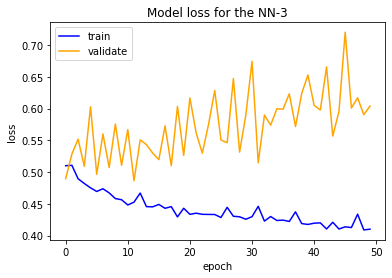

In [49]:
#Plot loss results for training data and testing data 
plt.plot(history_NN3_50.history['loss'], 'blue')
plt.plot(history_NN3_50.history['val_loss'], 'orange')
plt.title('Model loss for the NN-3')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')


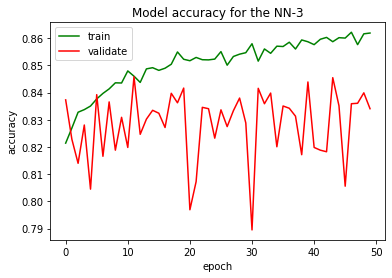

In [50]:
#Plot accuracy results for training data and testing data 
plt.plot(history_NN3_50.history['accuracy'], 'green')
plt.plot(history_NN3_50.history['val_accuracy'], 'red')
plt.title('Model accuracy for the NN-3')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')

Re-train the NN-6 with 50 epochs, and plot the loss and accuracy

In [51]:
# NN-6, 50 epochs
history_NN6_50=model_6.fit(X_train_3D, y_train, epochs=50, validation_split=0.2)

test_loss, test_acc = model_6.evaluate(X_test_3D, y_test)
print("Model - 6 layers - test loss:", test_loss * 100)
print("Model - 6 layers - test accuracy:", test_acc * 100)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 4s 85us/sample - loss: 0.3848 - accuracy: 0.8608 - val_loss: 0.4311 - val_accuracy: 0.8474
Epoch 2/50
48000/48000 [==============================] - 4s 89us/sample - loss: 0.3675 - accuracy: 0.8659 - val_loss: 0.3851 - val_accuracy: 0.8672
Epoch 3/50
48000/48000 [==============================] - 4s 90us/sample - loss: 0.3547 - accuracy: 0.8694 - val_loss: 0.4039 - val_accuracy: 0.8618
Epoch 4/50
48000/48000 [==============================] - 4s 89us/sample - loss: 0.3399 - accuracy: 0.8776 - val_loss: 0.4235 - val_accuracy: 0.8568
Epoch 5/50
48000/48000 [==============================] - 4s 85us/sample - loss: 0.3368 - accuracy: 0.8776 - val_loss: 0.4072 - val_accuracy: 0.8639
Epoch 6/50
48000/48000 [==============================] - 4s 85us/sample - loss: 0.3199 - accuracy: 0.8825 - val_loss: 0.3649 - val_accuracy: 0.8704
Epoch 7/50
48000/48000 [==============================] 

Model - 6 layers - test loss: 53.41969158053398
Model - 6 layers - test accuracy: 87.59999871253967


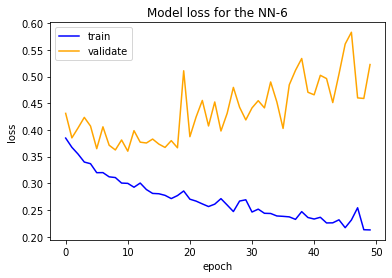

In [52]:
#Plot loss results for training data and testing data
plt.plot(history_NN6_50.history['loss'], 'blue')
plt.plot(history_NN6_50.history['val_loss'], 'orange')
plt.title('Model loss for the NN-6')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')


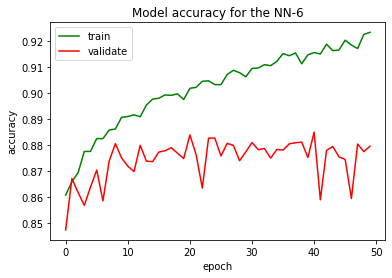

In [53]:
#Plot accuracy results for training data and testing data 
plt.plot(history_NN6_50.history['accuracy'], 'green')
plt.plot(history_NN6_50.history['val_accuracy'],'red')
plt.title('Model accuracy for the NN-6')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')

##  Build Convolutional Neural Network(CNN) with open-source neural-network library, Keras on Fashion-MNIST dataset


train a Convolutional Neural Network classifier with 1 convolution layer using the Keras deep learning library
Also use batch normalization to preprocess every layer of the network
model is first trained for 10 epochs with batch size of 256, compiled with categorical_crossentropy loss function and Adam optimizer. Then, I added data augmentation which generates new training samples by rotating, shifting and zooming on the training samples, and trained for another 50 epochs.



In [174]:
X_test_cnn1.shape

(10000, 784)

In [175]:
y_test_cnn1.shape

(10000,)

In [176]:
X_train_cnn1.shape

(60000, 784)

In [177]:
y_train_cnn1.shape

(60000,)

In [57]:
from sklearn.model_selection import train_test_split


In [178]:
# Here I split original training data to sub-training (80%) and validation data (20%)
X_train_cnn1, X_val, y_train_cnn1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

In [179]:
X_train_cnn1.shape

(48000, 784)

In [180]:
y_train_cnn1.shape

(48000,)

## Processing Data

After loading and splitting the data, I preprocess them
by reshaping them into the shape the network expects and scaling them so that all values are in the [0,1]interval.The training data were stored in an array of shape(60000,28,28)of type uint8 with values in the [0,255] interval. I transform it into a float32 array of shape(60000,28*28)with values between 0 and 1

In [182]:
# Each image's dimension is 28 x 28
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

# Prepare the training images
X_train_cnn1 = X_train_cnn1.reshape(X_train_cnn1.shape[0], img_rows, img_cols, 1)
X_train_cnn1 = X_train_cnn1.astype('float32')
X_train_cnn1 /= 255

# Prepare the test images
X_test_cnn1 = X_test_cnn1.reshape(X_test_cnn1.shape[0], img_rows, img_cols, 1)
X_test_cnn1 = X_test_cnn1.astype('float32')
X_test_cnn1 /= 255

# Prepare the validation images
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_val = X_val.astype('float32')
X_val /= 255




The problem is with your label-data shape. In a multiclass problem you are predicting the probabibility of every possible class, so must provide label data in (N, m) shape, where N is the number of training examples, and m is the number of possible classes (3 in your case).

Keras expects y-data in (N, 3) shape, not (N,) as you've problably provided, that's why it raises an error.

Use e.g. OneHotEncoder to convert your label data to one-hot encoded form

In [128]:
def one_hot(y, n_labels):
    mat = np.zeros((len(y), n_labels))
    for i, val in enumerate(y):
        mat[i, val] = 1
    return mat

In [129]:
# X_train, y_train,X_val,y_val
X_train.shape
y_train.shape
X_val.shape
y_val.shape

(12000,)

In [184]:
y_train_enc = one_hot(y_train_cnn1, 10)
y_train_enc.shape
y_val_enc = one_hot(y_val,10)
y_val_enc.shape
y_test_enc = one_hot(y_test_cnn1,10)
y_test_enc.shape

(10000, 10)

## CNN with 1Convolutional Layers
This CNN takes as input tensors of shape(image_height,image_width,image_channels). In this case, I configure the CNN to process inputs of size(28,28,1) which is the format of the FashionMNIST images. I do this by passing the argument input_shape=(28,28,1) to the first layer

* The *Conv2D* layers are used for the **convolution** operation that extracts features from the input images by sliding a convolution filter over the input to produce a feature map. Here I choose feature map with size 3 x 3. 
* The *MaxPooling2D* layers are used for the **max-pooling** operation that reduces the dimensionality of each feature, which helps shorten training time and reduce number of parameters. Here I choose the pooling window with size 2 x 2.
* To normalize the input layers, I use the *BatchNormalization* layers to adjust and scale the activations. **Batch Normalization** reduces the amount by what the hidden unit values shift around (covariance shift). Also, it allows each layer of a network to learn by itself a little bit more independently of other layers.
* To combat overfititng, I use the *Dropout* layers, a powerful regularization technique. **Dropout** is the method used to reduce overfitting. It forces the model to learn multiple independent representations of the same data by randomly disabling neurons in the learning phase. For example, the 1st dropout layer will randomnly disable 25% of the outputs.
* In total, this model has 4 *Conv2D* layers, 2 *MaxPooling* layers, 6 *BatchNormalization* layers, and 5 *Dropout* layers.
* The next step is to feed the last output tensor into a stack of *Dense* layers, otherwise known as **fully-connected** layers. These densely connected classifiers process vectors, which are 1D, whereas the current output is a 3D tensor. Thus, I need to **flatten** the 3D outputs to 1D, and then add 2 *Dense* layers on top.
* I do a 10-way classification (as there are 10 classes of fashion images), using a final layer with 10 outputs and a softmax activation. **Softmax** activation enables me to calculate the output based on the probabilities. Each class is assigned a probability and the class with the maximum probability is the model’s output for the input.


In [185]:
# Import Keras libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(10, activation='softmax'))

When compiling the model, I choose **categorical_crossentropy** as the loss function (which is relevent for multiclass, single-label classification problem) and **Adam** optimizer.
* The cross-entropy loss calculates the error rate between the predicted value and the original value. The formula for calculating cross-entropy loss is given [here](https://en.wikipedia.org/wiki/Cross_entropy). Categorical is used because there are 10 classes to predict from. If there were 2 classes, I would have used binary_crossentropy.
* The Adam optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is responsible for updating the weights of the neurons via backpropagation. It calculates the derivative of the loss function with respect to each weight and subtracts it from the weight. That is how a neural network learns.

In [186]:
cnn1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

## how the dimensions of the feature maps change with every successive layer

In [187]:
cnn1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               692352    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
________________________________________________

* 1,219,754 parameters are available to be trained.
* The output of the *Conv2D* and *MaxPooling2D* layers are 3D tensors of shape *(height, width, channels)*.
* The number of channels is controlled by the 1st argument passed to the *Conv2D* layer (32).
* The (4, 4, 128) outputs from the 3rd *Dropout* layer are flattened into vectors of shape (2048,) before going through 3 *Dense* layers.

## Training the Model
As previously mentioned, I train the model with batch size of 256 and 10 epochs on both training and validation data.

In [188]:
y_val.shape

(12000,)

In [189]:
history1 = cnn1.fit(X_train_cnn1, y_train_enc,
          batch_size=256,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val_enc))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 20s 422us/step - loss: 1.6435 - accuracy: 0.4950 - val_loss: 0.9892 - val_accuracy: 0.6608
Epoch 2/10
48000/48000 [==============================] - 20s 415us/step - loss: 0.8391 - accuracy: 0.7043 - val_loss: 0.7414 - val_accuracy: 0.7343
Epoch 3/10
48000/48000 [==============================] - 20s 421us/step - loss: 0.6968 - accuracy: 0.7441 - val_loss: 0.6616 - val_accuracy: 0.7566
Epoch 4/10
48000/48000 [==============================] - 21s 434us/step - loss: 0.6362 - accuracy: 0.7654 - val_loss: 0.6171 - val_accuracy: 0.7773
Epoch 5/10
48000/48000 [==============================] - 19s 386us/step - loss: 0.5927 - accuracy: 0.7816 - val_loss: 0.5806 - val_accuracy: 0.7901
Epoch 6/10
48000/48000 [==============================] - 18s 372us/step - loss: 0.5647 - accuracy: 0.7935 - val_loss: 0.5550 - val_accuracy: 0.7984
Epoch 7/10
48000/48000 [==============================] 

In [190]:
score1 = cnn1.evaluate(X_test_cnn1, y_test_enc, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 84.49653713684081
Test accuracy: 0.708299994468689


## Data Augmentation
Overfitting can be caused by having too few samples to learn from, making me unable to train a model that can generalize to new data. Given infinite data, my model would be exposed to every possible aspect of the data distribution at hand: I would never overfit. 

**Data augmentation** takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, my model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ImageDataGenerator instance.
* *rotation_range* is a value in degrees (0–180), a range within which to randomly rotate pictures.
* *width_shift* and *height_shift* are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* *shear_range* is for randomly applying shearing transformations.
* *zoom_range* is for randomly zooming inside pictures.

In [191]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train_cnn1, y_train_enc, batch_size=256)
val_batches = gen.flow(X_val, y_val_enc, batch_size=256)

Train the network using data augmentation

In [192]:
history1 = cnn1.fit_generator(batches, steps_per_epoch=48000//256, epochs=50,
                    validation_data=val_batches, validation_steps=12000//256, use_multiprocessing=True)

Epoch 1/50
187/187 [==============================] - 27s 146ms/step - loss: 0.7466 - accuracy: 0.7171 - val_loss: 0.7102 - val_accuracy: 0.7361
Epoch 2/50
187/187 [==============================] - 28s 150ms/step - loss: 0.6965 - accuracy: 0.7350 - val_loss: 0.6040 - val_accuracy: 0.7412
Epoch 3/50
187/187 [==============================] - 27s 146ms/step - loss: 0.6752 - accuracy: 0.7448 - val_loss: 0.6468 - val_accuracy: 0.7540
Epoch 4/50
187/187 [==============================] - 29s 152ms/step - loss: 0.6613 - accuracy: 0.7491 - val_loss: 0.5971 - val_accuracy: 0.7613
Epoch 5/50
187/187 [==============================] - 28s 150ms/step - loss: 0.6512 - accuracy: 0.7553 - val_loss: 0.6359 - val_accuracy: 0.7584
Epoch 6/50
187/187 [==============================] - 90s 483ms/step - loss: 0.6394 - accuracy: 0.7574 - val_loss: 0.6522 - val_accuracy: 0.7684
Epoch 7/50
187/187 [==============================] - 40s 211ms/step - loss: 0.6296 - accuracy: 0.7636 - val_loss: 0.6128 - val_ac

In [193]:
score1 = cnn1.evaluate(X_test_cnn1, y_test_enc, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 219.8957384765625
Test accuracy: 0.5608000159263611


Results 
Plot training and validation accuracy as well as training and validation loss

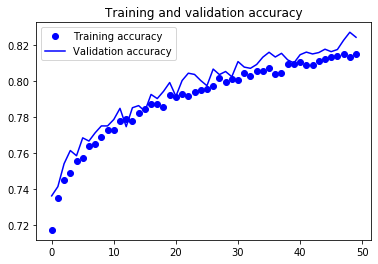

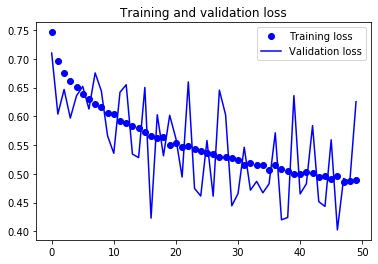

In [194]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Confusion Matrix

In [167]:
X_test.shape

(10000, 28, 28, 1)

In [195]:
cnn1_predict=cnn1.predict(X_test_cnn1)
cnn1_predict_cm = [np.argmax(t) for t in cnn1_predict]

In [196]:
y_test_cm = [np.argmax(t) for t in y_test_enc]

In [197]:
cnn1_cm = confusion_matrix(y_test_cm, cnn1_predict_cm)

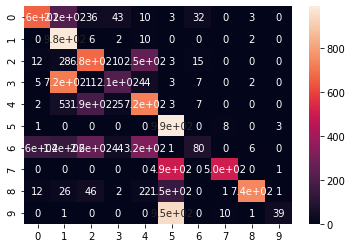

In [198]:
sns.heatmap(cnn1_cm,annot=True)